# Characterization of IBMQ devices using Qiskit Pulse

Based on:

- [Calibrating Qubits with Qiskit Pulse](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html) (Qiskit textbook)

- [Relaxation and Decoherence](https://qiskit.org/documentation/tutorials/noise/2_relaxation_and_decoherence.html) (Qiskit documentation)

- [Building Pulse Schedules](https://qiskit.org/documentation/tutorials/circuits_advanced/06_building_pulse_schedules.html) (Qiskit documentation)

- [Qiskit Aer: Pulse simulation of two qubits using a Duffing oscillator model](https://qiskit.org/documentation/tutorials/circuits_advanced/09_pulse_simulator_duffing_model.html) (Qiskit documentation)

- [Learn quantum computing with python and IBM quantum experience](https://github.com/PacktPublishing/Learn-Quantum-Computing-with-Python-and-IBM-Quantum-Experience/blob/master/Chapter11/Chapter%2011%20-%20Ignis.ipynb) (chapter 11 of the book - 'Ignis')

- [An introduction to open quantum systems](https://github.com/qiskit-community/qiskit-textbook/blob/master/content/ch-quantum-hardware/Open-quantum-systems.ipynb) (unfinished Qiskit notebook)



## Utilities

### Installation

In [ ]:
!pip install 'qiskit[visualization]' --quiet
save_and_load = True

     |████████████████████████████████| 6.0MB 881kB/s 
     |████████████████████████████████| 18.0MB 236kB/s 
     |████████████████████████████████| 235kB 36.2MB/s 
     |████████████████████████████████| 215kB 44.1MB/s 
     |████████████████████████████████| 2.1MB 34.6MB/s 
     |████████████████████████████████| 163kB 36.7MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 1.5MB 33.3MB/s 
     |████████████████████████████████| 194kB 44.0MB/s 
     |████████████████████████████████| 112kB 44.7MB/s 
     |████████████████████████████████| 614kB 32.8MB/s 
     |████████████████████████████████| 3.2MB 33.2MB/s 
     |████████████████████████████████| 6.3MB 32.3MB/s 
ERROR: qiskit-aqua 0.9.1 has requirement retworkx<=0.8.0,>=0.7.0, but you'll have retworkx 0.9.0 which is incompatible.


### Basic imports and backend qubit defaults

In [ ]:
import random, numpy as np, matplotlib.pyplot as plt, pickle
from scipy.optimize import curve_fit
from google.colab import files
from qiskit import execute
from qiskit import pulse            
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib
from qiskit.ignis.characterization.calibrations import rabi_schedules,RabiFitter
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

from qiskit import IBMQ
API_KEY = 'd1e0708e9ea899bf5a17e43c1b948223b9c9b66e19dfb58a40fc20b0ee383b8595ef447b340a57fa6e3b9da49c9711efbec30a8a68c77ab235e42662cbba1a62'

if save_and_load: # First time run.
  IBMQ.save_account(API_KEY, overwrite=True)
  IBMQ.load_account()
  save_and_load = False

# Channel delays seem to have to be multiples of 16 for >1 qubit backends?
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

specific_choice = False
nqubits = None

mock_backend = False
if mock_backend:
  from qiskit.providers.aer import PulseSimulator
  from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk
  from qiskit.providers.aer.pulse import PulseSystemModel
  armonk_backend = FakeArmonk()
  armonk_model = PulseSystemModel.from_backend(armonk_backend)
  backend = PulseSimulator()
  # Must change functions too. See https://qiskit.org/documentation/tutorials/circuits_advanced/10_pulse_simulator_backend_model.html
elif nqubits is not None and nqubits==1:
  provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
  backend = provider.get_backend('ibmq_armonk')
  print("Selected single qubit backend: ", backend, end="")
elif specific_choice:
  provider=IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
  backend = provider.get_backend('ibmq_guadalupe')
  print("Selected backend: ", backend, end="")
else:
  provider=IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
  conditional_backends = provider.backends(filters=lambda x: 
                            (nqubits is None or x.configuration().n_qubits==nqubits)
                            and not x.configuration().simulator 
                            and x.configuration().backend_name!='ibmq_guadalupe'
                            and x.configuration().open_pulse is True)
  backend = least_busy(conditional_backends)
  print("Selected least busy backend: ", backend,end="")


q = 0 # The index of the qubit to be considered.

defaults = backend.defaults()
properties = backend.properties()
time_unit = properties.gate_length("id", [q])
print(" (time resolution: %.2f ns)" % (time_unit*1e9))
configuration = backend.configuration()
job_limit = backend.job_limit()
maxjobs = job_limit.maximum_jobs
print("Maximum pending jobs allowed per user: ", 
      "no limit" if maxjobs is None else maxjobs)
print(configuration.to_dict())


t1_est = properties.t1(q)
t2_est = properties.t2(q)
freq_est = properties.frequency(q) 
# ^Same as backend.defaults().qubit_freq_est[0] which is the default for driving
#channel.

print("The estimated backend properties for qubit %d are:" % q)
print("* Resonance frequency: %.2f gigahertz" % (freq_est*1e-9))
print("* T1 time: %.1f microseconds" % (t1_est*1e6))
print("* T2 time: %.1f microseconds" % (t2_est*1e6))

Selected least busy backend:  ibmq_toronto (time resolution: 35.56 ns)
Maximum pending jobs allowed per user:  no limit
{'backend_name': 'ibmq_toronto', 'backend_version': '1.4.28', 'n_qubits': 27, 'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'gates': [{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21],

### Data collection functions

For gathering organized data for the inference, and saving to files. 

Will be used when gathering data for the inference, in the sections:

- [*Running a Ramsey experiment*](#ramsey)
- [*Running an echoed Ramsey experiment (using opposite detunings)*](#echoed_ramsey)
- [*Performing a Hahn Echo experiment to get an estimate of T2*](#T2)
- [*Performing an experiment to get the energy relaxation time T1*](#T1)

In [ ]:
def assemble_data_vector(times, job):
    result = job.result(timeout=120)
    results = result.get_counts()
    data = []
    for i,dict in enumerate(results):
        # Shuffle each count because otherwise 0 results always come first
        #(undesirable for the inference).
        new_data = []
        for key in dict:
            outcome = int(key)
            # Use times in microseconds.
            datum = (times[i]*1e6,outcome)
            new_data.extend([datum for shot in range(dict[key])])
        random.shuffle(new_data)
        data.extend(new_data)
    return data

def download_data(job, times, filename_start, index):
  data = assemble_data_vector(times, job)
  filename = filename_start + ('_%d.data' % index)
  print("Run %d data vector (length %d): " % (index,len(data)), data)
  with open(filename, 'wb') as filehandle:
      pickle.dump(data, filehandle)
  files.download(filename)

def collect_data(job_function, times, runs, nshots, filename_start, 
                 job_list = None):
  if job_list is not None:
      print(" Will use the %d jobs from list given [collect_data]." % 
            len(job_list))
      for i,job_ID in enumerate(job_list):
          job = backend.retrieve_job(job_ID)
          job_monitor(job)
          download_data(job, times, filename_start, i)
      return

  jobs = []
  i, j = 0, 0 # Counters for submitted and collected jobs respectively.
  try:
      # Submit maximum parallel jobs allowed per user in the backend.
      for c in range(min(runs,float('inf') if maxjobs is None else maxjobs)): 
          print("> Run %d." % i)
          job = job_function(times,nshots=nshots,monitor=False)
          jobs.append(job)
          i += 1
      # Retrieve oldest submitted when possible and submit next: will queue 1 more 
      #job (next 'i' up) when allowed, and download jth's data.
      while i<runs:
          job_monitor(jobs[0]) # Blocking instruction, 
          # When oldest submitted and unretrieved has finished:
          download_data(jobs[0], times, filename_start, j)
          # Remove the one already arranged into a data vector and submit 1 more.
          jobs = jobs[1:]; j += 1
          job = job_function(times,nshots=nshots,monitor=False)
          jobs.append(job); i += 1
      # Retrieve leftover jobs if they exist.
      while j<runs:
          job_monitor(jobs[0]) # Wait for completion.
          download_data(jobs[0], times, filename_start, j)
          jobs = jobs[1:]; j += 1
  except KeyboardInterrupt:
      print("Quit due to keyboard interrupt.")

## Determining T1 from experiments (using a Qiskit fitter)

T1 job ID: '60b911a5e6595b4717bfac78'
Job Status: job has successfully run
Estimated parameters for model P(1)=A.exp(-t/T1)+B:
* A  = 0.70 ± 0.01
* T1 = 71.84 ± 3.77 microseconds
* B  = 0.19 ± 0.02
(Estimated backend T1 is 48.69 microseconds.)


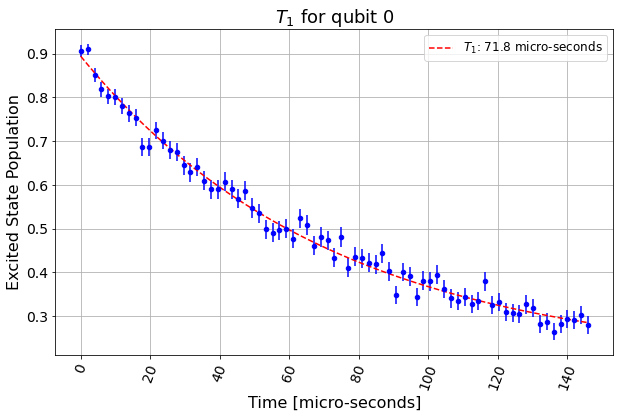

In [ ]:
from qiskit.ignis.characterization.coherence import t1_circuits, T1Fitter

run_again = True
if run_again:
    ngates = np.linspace(0, 3*t1_est/time_unit, 75, dtype='int')
    gate_time = time_unit*1e6 # In microseconds.
    t1_circs, t1_delays = t1_circuits(ngates, gate_time, [q])
    t1_job = execute(t1_circs, backend, shots=512)
    print(f"T1 job ID: \'{t1_job.job_id()}\'")
else:
    t1_job = backend.retrieve_job('60b7bbe19af47d6e4e2d1caf')
    # Paris, np.linspace(0, 2*t1_est/time_unit, 75, dtype='int')
job_monitor(t1_job)
t1_result = t1_job.result()

# Parameters by order (A,T1,B) for P(1)=A*e**(-t/T1)+B
t1_fit = T1Fitter(t1_result, t1_delays, [q],
                  fit_p0=[1, t1_est*1e6, 0],
                  fit_bounds=([0, 0, 0], [1, 2*t1_est*1e6, 1]))

print("Estimated parameters for model P(1)=A.exp(-t/T1)+B:")
labels = ["A ","T1","B "]
# First zero to index qubit from all measured (1), second to extract single list.
params = t1_fit.params['0'][0]
errors = t1_fit.params_err['0'][0]
for i in range(len(params)):
    print("* %s = %.2f ± %.2f" % (labels[i],params[i],errors[i]),end="")
    extra = " microseconds" if str(labels[i])[0]=='T'else ""
    print(extra)
print(f"(Estimated backend T1 is {round(t1_est*1e6,2)} microseconds.)")

fig,ax = plt.subplots(figsize=(10, 6))
t1_fit.plot(0,ax=ax)
plt.show()

## Determining T2 from experiments (using a Qiskit fitter)

Estimated parameters for model P(0)=A.exp(-t/T2)+B:
* A  = 0.44 ± 0.01
* T2 = 86.49 ± 5.80 microseconds
* B  = 0.55 ± 0.01
(Estimated backend T2 is 90.23 microseconds.)


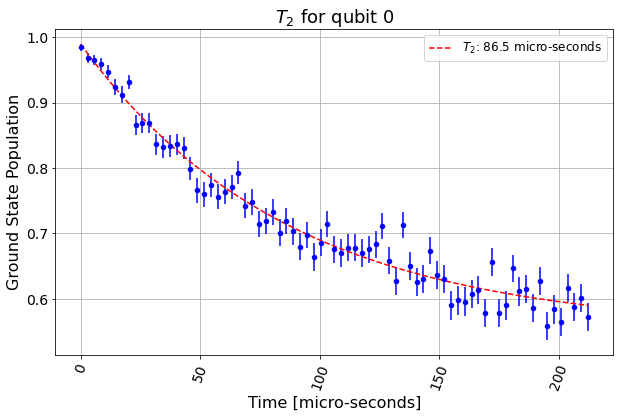

In [ ]:
from qiskit.ignis.characterization.coherence import t2_circuits, T2Fitter

run_again = False
if run_again:
    ngates = np.linspace(0, 2*t2_est/(2*time_unit), 75, dtype='int')
    gate_time = time_unit*1e6 # In microseconds.
    t2_circuits, t2_delays = t2_circuits(ngates, gate_time, [q])

    t2_job = execute(t2_circuits, backend, shots=512,optimization_level=0)
    print(f"T2 job ID: \'{t2_job.job_id()}\'")
    job_monitor(t2_job)
else:
    #t2_job = backend.retrieve_job('60b66e594c7440e1ed3ff1c9') # 1024 shots.
    #t2_job = backend.retrieve_job('60b67105d48a832c7e9790b7') # 20 shots.
    #t2_job = backend.retrieve_job('60b6786c7a767885789f839c') # 512 shots.
    # All 3 with t2_est = 76.51 (Rome, 01/06), (0,4000,75)
    t2_job = backend.retrieve_job('60b7a92201804785e39153f1') # 512 shots.
    

t2_result = t2_job.result()

# Parameters by order (A,T2,B) for P(0)=A*exp(-t/T2)+B
t2_fit = T2Fitter(t2_result, t2_delays, [q], 
                      fit_p0=[0.5, t2_est*1e6, 0.5], 
                      fit_bounds=([0, 0, 0], [1, 2*t2_est*1e6, 1]),
                      time_unit='micro-seconds')

print("Estimated parameters for model P(0)=A.exp(-t/T2)+B:")
labels = ["A ","T2","B "]
# First zero to index qubit from all measured (1), second to extract single list.
params = t2_fit.params[str(0)][0] 
errors = t2_fit.params_err[str(0)][0]
for i in range(len(params)):
    print("* %s = %.2f ± %.2f" % (labels[i],params[i],errors[i]),end="")
    extra = " microseconds" if str(labels[i])[0]=='T'else ""
    print(extra)
print(f"(Estimated backend T2 is {round(t2_est*1e6,2)} microseconds.)")

fig,ax = plt.subplots(figsize=(10, 6))
t2_fit.plot(0,ax=ax)
plt.show()

## Determining T2* from experiments (using a Qiskit fitter)

T2* job ID: '60b940966b8ea85ae9910a86'
Estimated parameters for model P(0)=A.exp(-t/T2).cos(2.pi.f.t+φ)+B:
* A   = 0.47 ± 0.00
* T2* = 20.57 ± 1.44 microseconds
* f   = 0.99 ± 0.00
* phi = 0.00 ± 0.02
* B   = 0.53 ± 0.00


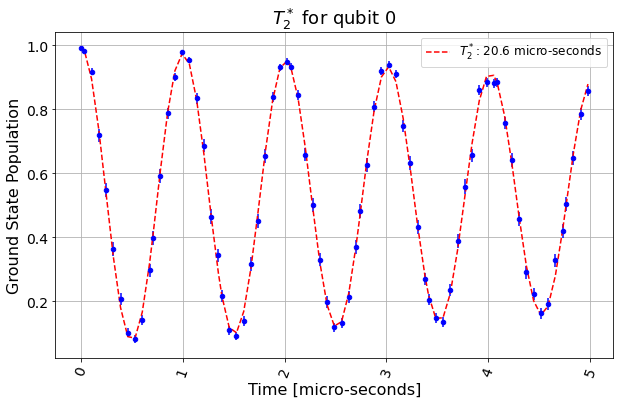

In [ ]:
from qiskit.ignis.characterization.coherence import t2star_circuits, T2StarFitter

ngates_star = np.linspace(0, 5e-6/time_unit, 75, dtype='int')
gate_time = time_unit*1e6
t2star_circs, t2star_delays, osc_freq = \
                          t2star_circuits(ngates_star, gate_time, [q], nosc=5)

run_again = True 
if run_again:
    t2star_job = execute(t2star_circs, backend, shots=512, optimization_level=0)
    print(f"T2* job ID: \'{t2star_job.job_id()}\'")
else:
    t2star_job = backend.retrieve_job('609a9eec752f3b2d2b4e3056')
    # np.linspace(10, 100, 50, dtype='int') for 6099773f016639105426250e
t2star_result = t2star_job.result()

t2star0 = 10

#Parameters by order (A,T2*,f,phi,B) for P(1)=A.exp(-t/T2*)*cos(2pi*f*t+phi)+B
t2star_fit = T2StarFitter(t2star_result, t2star_delays, [q],
                          fit_p0=[0.5, t2star0, osc_freq, 0, 0.5],
                          fit_bounds=([0, 0, 0, 0, 0],
                                      [1, 40, 2*osc_freq, 2*np.pi, 1]),
                          time_unit='micro-seconds')

print("Estimated parameters for model P(0)=A.exp(-t/T2).cos(2.pi.f.t+φ)+B:")
labels = ["A  ","T2*","f  ","phi","B  "]
params = t2star_fit.params[str(q)][0]
errors = t2star_fit.params_err[str(q)][0]
for i in range(len(params)):
    print("* %s = %.2f ± %.2f" % (labels[i],params[i],errors[i]),end="")
    extra = " microseconds" if str(labels[i])[0]=='T'else ""
    print(extra)

fig,ax = plt.subplots(figsize=(10, 6))
t2star_fit.plot(0,ax=ax)
plt.show()

## Calibrating pulses

Creating personalized pi ($σ_x$) and half-pi (*H*) pulses by doing a Rabi experiment (amplitude sweep to determine the wave half-period).

### Getting the pulse amplitude with a Rabi experiment

/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Rabi job ID: '60bbdee09cd20ef5d48597cb' [run_rabi_job]
Job Status: job has successfully run


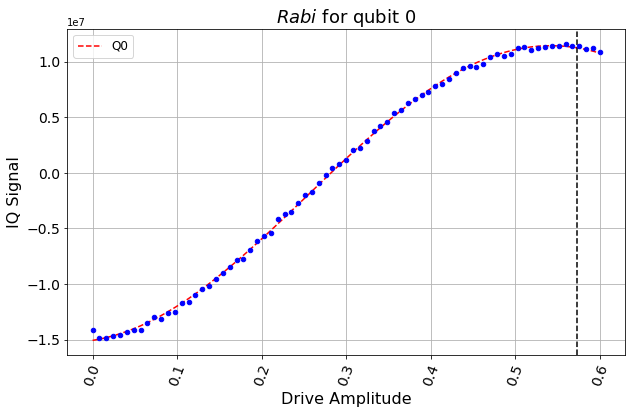

Pi pulse amplitude: 0.5724310310942751


In [ ]:
def run_rabi_job(drive_amps, drive_sigma, drive_duration):
    # List of drive channels.
    drive_channel = pulse.DriveChannel(q)
    drive_channels = [drive_channel]

    # Get the schedules.
    rabi_sched, amps = rabi_schedules(amp_list=drive_amps,
                           qubits=[q],
                           pulse_width=drive_duration,
                           pulse_sigma=drive_sigma,
                           drives=drive_channels,
                           inst_map=backend.defaults().instruction_schedule_map,
                           meas_map=backend.configuration().meas_map)

    rabi_job = backend.run(rabi_sched,
                    #schedule_los=[{drive_channel: freq_est}]*len(drive_amps),
                    meas_level=1,
                    meas_return='avg',
                    shots=8192)
    ID = rabi_job.job_id()
    print(f"Rabi job ID: \'{ID}\' [run_rabi_job]")
    job_monitor(rabi_job)
    return(rabi_job)

def get_pi_pulse_amplitude(rabi_job, amps, show=False):
    rabi_results = rabi_job.result()
    rabi_fit = RabiFitter(rabi_results, amps, [q], 
                          fit_p0 = [3.5e14, 2, 0.5, -0.5e14])
    pi_amp = rabi_fit.pi_amplitude(0)
    if show:
        fig,ax = plt.subplots(figsize=(10, 6))
        rabi_fit.plot(q, ax=ax)
        plt.show()
        print(f"Pi pulse amplitude: {pi_amp}")
    return(pi_amp)

run_again = True
if run_again:
    # Pick the parameters for the gaussian drive pulses (width + truncation).
    # Durations (in samples) should be the same as used in the Rabi schedules.
    drive_sigma = 8
    drive_duration = 8*16 # Should be a multiple of 16.
    amps = np.linspace(0, 0.6, 75)
    rabi_job = run_rabi_job(amps, drive_sigma, drive_duration)
else:
    drive_sigma = 8
    drive_duration = 8*16 # Should be a multiple of 16.
    amps = np.linspace(0, 0.4, 75)
    job_ID = '60bbaf70a8e98d7c49bcc4ca'
    rabi_job = backend.retrieve_job(job_ID)
    
pi_amp = get_pi_pulse_amplitude(rabi_job, amps, show=True)

### Defining custom pulses 

These are necessarily if building the schedules from scratch, which allows for improved precision; if this is not necessary, the default pulse instructions can be used instead.

In [ ]:
'''
These will be necessary later if building schedules instead of using the 
default pulses from the pulse builder interface.
Method 0 gives pulses (waveforms), method 1 gives schedules. The former can be
used as an argument to Pulse.Play(), the latter in the pulse.call() 
construction. 
'''

def get_pi_pulse(method=1):
    if method==0:
        pi_pulse = pulse_lib.gaussian(duration=drive_duration,
                                      amp=pi_amp, 
                                      sigma=drive_sigma,
                                      name='pi')
    else:
        inst_sched_map = defaults.instruction_schedule_map
        pi_pulse = inst_sched_map.get('x',qubits=[q])
    return pi_pulse

def get_half_pi_pulse(method=1):
    if method==0:
        half_pi_amp = pi_amp/2
        drive_durationII = get_closest_multiple_of_16(drive_duration/2)
        half_pi_pulse = pulse_lib.gaussian(duration=drive_durationII,
                                            amp=half_pi_amp, 
                                            sigma=drive_sigma,
                                            name='half_pi')
    else:
        inst_sched_map = defaults.instruction_schedule_map
        half_pi_pulse = inst_sched_map.get('u2',[q],0,np.pi)
    return half_pi_pulse

def get_measure_pulse():
    inst_sched_map = defaults.instruction_schedule_map
    measure = inst_sched_map.get('measure',qubits=[q])
    # Includes stimulus + acquisiton.
    return measure

### Testing the pulses

In [ ]:
 measure = get_measure_pulse() 
 pi_pulse = get_pi_pulse(method=0)
 half_pi_pulse = get_half_pi_pulse(method=0)
 dq = pulse.DriveChannel(q)

schedule0 = pulse.Schedule(name="|0>")
schedule0 += measure

hschedule = pulse.Schedule(name="|+>")
hschedule += Play(half_pi_pulse, dq)  
hschedule += measure << hschedule.duration

schedule1 = pulse.Schedule(name="|1>")
schedule1 += Play(pi_pulse, dq)  
schedule1 += measure << schedule1.duration

run_again = False
if run_again:
    job = backend.run([schedule0, hschedule, schedule1],
                              meas_level=2,
                              shots=2048)
    print("Job ID: \'%s\'." % job.job_id())
    job_monitor(job)
else:
    job = backend.retrieve_job('60bbcca4a8e98d02ebbcc64d')

result = job.result()

p0s = []
for count_dict in result.get_counts():
  p0 = 0
  for key in count_dict:
    if key[-1]=='0':
      p0 += count_dict[key]
  p0 = p0/len(count_dict)
  p0s.append(p0)

print("Preparation-measurement rates:")
print("- Measured 0 after a pi pulse:       %.1f%%" % ((p0s[2])*100))
print("- Measured 0 after a half pi pulse: %.1f%%" % ((p0s[1])*100))
print("- Measured 0 after no pulses:       %.1f%%" % (p0s[0]*100))

Preparation-measurement rates:
- Measured 0 after a pi pulse:       9.9%
- Measured 0 after a half pi pulse: 50.1%
- Measured 0 after no pulses:       90.9%


In [ ]:
with pulse.build(backend) as hschedule_def:
  with pulse.align_sequential():
    pulse.u2(0,np.pi,q)
    pulse.call(measure)  

with pulse.build(backend) as schedule1_def:
  with pulse.align_sequential():
    pulse.x(q)
    pulse.call(measure)

run_again = False
if run_again:
    job = backend.run([hschedule_def, schedule1_def],
                              meas_level=2,
                              shots=2048)
    print("Job ID: \'%s\'." %job.job_id())
    job_monitor(job)
else:
    job = backend.retrieve_job('60bbacc01c8d4f39291fdce3')

result = job.result()

p0s = []
for count_dict in result.get_counts():
  p0 = 0
  for key in count_dict:
    if key[-1]=='0':
      p0 += count_dict[key]
  p0 = p0/len(count_dict)
  p0s.append(p0)

print("Preparation-measurement rates:")
print("- Measured 0 after a pi pulse:      %.1f%%" % ((p0s[1])*100))
print("- Measured 0 after a half pi pulse: %.1f%%" % ((p0s[0])*100))

Preparation-measurement rates:
- Measured 0 after a pi pulse:      11.2%
- Measured 0 after a half pi pulse: 50.8%


## <a name="ramsey"></a>Running a Ramsey experiment

In [ ]:
def get_ramsey_schedules(ts, delta_f, method=2):
    # Need to convert evolution times to backend time units/samples.
    with pulse.build(backend):
      samples = pulse.builder.seconds_to_samples(ts)
    delays = np.array([get_closest_multiple_of_16(nsamples) 
                       for nsamples in samples])

    if method<2:
        half_pi = get_half_pi_pulse(q,defaults) 
        measure = get_measure_pulse(q,defaults) 
        drive_channel = pulse.DriveChannel(q)
    else:
        mq = pulse.MeasureChannel(q)
    ramsey_schedules = []
    
    for i,delay in enumerate(delays):
        if method==0:
              schedule = pulse.Schedule(name=f"Ramsey delay no. {i}")
              schedule += pulse.Play(half_pi, drive_channel)
              schedule += pulse.Delay(int(delay),drive_channel)
              schedule += pulse.Play(half_pi, drive_channel)
              schedule += pulse.Delay(int(schedule.duration),mq)
              schedule += measure
        elif method==1:
              schedule = pulse.Schedule(name=f"Ramsey delay no. {i}")
              schedule += pulse.Play(half_pi, drive_channel)
              # Delays/time shifts must be integers, so round these together.
              second_pulse_start = int(schedule.duration + delay) 
              schedule |= pulse.Play(half_pi, drive_channel) << second_pulse_start
              # Have to shift measure instructions because the channel is parallel.
              schedule += measure << int(schedule.duration) 
        elif method==2:
              with pulse.build(backend,name=f"Delay no. {i}") as schedule:
                with pulse.align_sequential():
                  pulse.u2(0,np.pi,q) # Half pi rotation.
                  # Delay can be in any channel assuming sequential alignment.
                  pulse.delay(delay,mq) 
                  pulse.u2(0,np.pi,q) 
                  pulse.measure(q)
        ramsey_schedules.append(schedule)
    #ramsey_schedules[4].draw()
    return ramsey_schedules

def run_ramsey_job(ts, delta_f, nshots=512, monitor=True):
    ramsey_schedules = get_ramsey_schedules(ts, delta_f)
    ramsey_frequency = freq_est + delta_f
    drive_channel = pulse.DriveChannel(q)
    # We'll override the default pulse frequencies to use the intended one.
    frequencies = [{drive_channel: ramsey_frequency} 
                   for i in range(len(ramsey_schedules))]
    ramsey_job = backend.run(ramsey_schedules,meas_level=2,shots=nshots,
                             schedule_los=frequencies)
    ID = ramsey_job.job_id()
    print(f"Ramsey job ID: '{ID}' [run_ramsey_job]")
    if monitor:
        job_monitor(ramsey_job)
    return ramsey_job

run_again = False
if run_again:
    delta_f = 1.83e6
    ts = np.linspace(0, 5e-6, 75) # The actual times in seconds.
    ramsey_job = run_ramsey_job(ts, delta_f)
else:
    delta_f = 1.83e6
    ts = np.linspace(0, 5e-6, 75)
    ramsey_job = backend.retrieve_job('60b93be0f120a76097b8fafb')

### Fitting a curve

Decaying likelihood curve fit:
* f  = 1.865619 ± 0.002183 MHz
* T2* = 13.769412 ± 2.659891 us


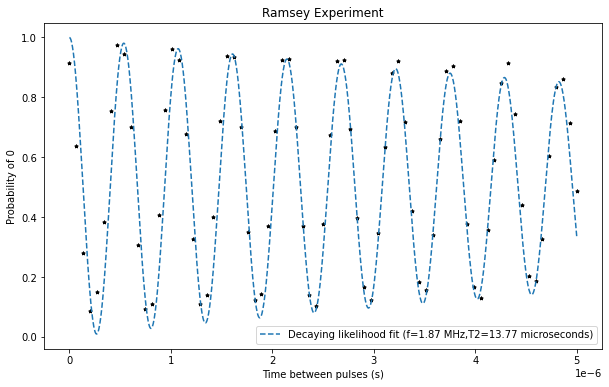

In [ ]:
def get_ramsey_values():
    ramsey_results = ramsey_job.result()
    ramsey_values = []
    results = ramsey_results.get_counts()
    for result in results:
        ramsey_values.append(result['0']/sum(result.values()))
    return(ramsey_values)

def decaying_likelihood(t, f, T2, pmax):
    return pmax*(np.exp(-t/T2)*np.cos(2*np.pi*f*t/2)**2+(1-np.exp(-t/T2))/2)

def fit_likelihood(ts, values, pmax, smoothen_interpolation=True, print_param=True):
    p0=[delta_f,10e-6]
    parameters,cov = curve_fit(lambda t,f,T2: decaying_likelihood(t,f,T2,pmax), 
                         ts, values, p0=p0)
    f,T2 = parameters
    ferr, T2err = np.sqrt(np.diag(cov))
    if print_param:
        print("Decaying likelihood curve fit:\n* f  = %.6f ± %.6f MHz\n"
              "* T2* = %.6f ± %.6f us"  % (f*1e-6,ferr*1e-6,T2*1e6,T2err*1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = decaying_likelihood(ts, *parameters, pmax)
    
    return parameters,ts,ys

def correct_frequency(offset=False):
    ramsey_values = get_ramsey_values()
    pmax = ramsey_values[0] if offset else 1
    (observed_f,_),_,_ = fit_likelihood(ts,ramsey_values,pmax,print_param=False)
    corrected_f = freq_est + (observed_f - delta_f)
    print("The backend frequency estimate was           %.8f GHz.\n" 
          "The Ramsey experiment yielded a frequency of %.8f GHz." 
          % (freq_est/1e9,corrected_f/1e9))
    return corrected_f

def plot_ramsey_fit(offset=False):
    ramsey_values = get_ramsey_values()
    pmax = ramsey_values[0] if offset else 1
    (f,T2),extended_ts,ys = fit_likelihood(ts,ramsey_values,pmax)
    plt.figure(figsize=(10, 6))
    plt.scatter(ts, ramsey_values, s=12, color='black', marker='*')
    curve_label = ("Decaying likelihood fit (f=%.2f MHz,T2=%.2f microseconds)" % 
                   (f/1e6,T2*1e6))
    plt.plot(extended_ts,ys,linestyle='dashed',label=curve_label)
    plt.title("Ramsey Experiment")
    plt.xlabel('Time between pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()

plot_ramsey_fit()

### Comparing the curve fit to the inference results

Decaying likelihood curve fit:
* f  = 1.865619 ± 0.002183 MHz
* T2* = 13.769412 ± 2.659891 us


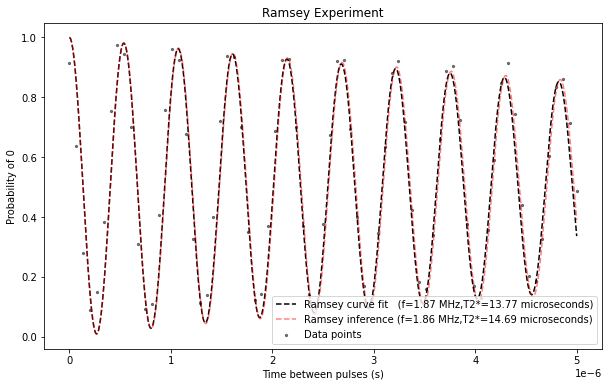

In [ ]:
def compare_inference(inference_params = [1.86,14.69]):
    pmax = 1
    ramsey_values = get_ramsey_values()
    (f,T2),extended_ts,ys = fit_likelihood(ts,ramsey_values,pmax)
    f2, T22 = inference_params
    f2, T22 = f2*1e6, T22*1e-6
    y2s = decaying_likelihood(extended_ts, f2, T22, pmax)

    plt.figure(figsize=(10, 6))
    plt.scatter(ts, ramsey_values, color='black',s=5,alpha=0.5,label='Data points')
    curve_label = ("Ramsey curve fit   (f=%.2f MHz,T2*=%.2f microseconds)" % 
                   (f/1e6,T2*1e6))
    curve_label2 = ("Ramsey inference (f=%.2f MHz,T2*=%.2f microseconds)" % 
                   (f2/1e6,T22*1e6))
    plt.plot(extended_ts,ys,color='black', linestyle='dashed',label=curve_label)
    plt.plot(extended_ts,y2s,color='red', linestyle='dashed',label=curve_label2,alpha=0.5)
    plt.title("Ramsey Experiment")
    plt.xlabel('Time between pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()

compare_inference()

### Getting data for the inference

In [ ]:
delta_f = 1.83e6
tmin, tmax = 1e-6, 5e-6
nsched = 75; nshots = 1; runs = 10
rand = False
if rand:
  times = np.array([random.uniform(tmin,tmax) for i in range(nsched)])
else:
  times = np.linspace(tmin, tmax, nsched)

filename_start = configuration.backend_name[5:] + '_ramsey_data[' +     \
    str(round(tmin*1e6*2,1)) + ',' +  str(round(tmax*1e6)) + '[' +      \
    'f=' + str(round(delta_f*1e-6,2))  + ('(rand)' if rand else '') +\
    '_sched=' + str(nsched) + '_nshots=' + str(nshots)

collect_data(lambda ts,nshots,monitor: run_ramsey_job(ts,delta_f, nshots=nshots,
                                                      monitor=monitor), 
             times, runs, nshots, filename_start)

> Run 0.


/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Ramsey job ID: '60b9401de6595bba5abfaf6b' [run_ramsey_job]
> Run 1.
Ramsey job ID: '60b9402142c6a9798af1011e' [run_ramsey_job]
> Run 2.
Ramsey job ID: '60b94026e22ce44df9c94453' [run_ramsey_job]
> Run 3.
Ramsey job ID: '60b9402abe6c30d00903559c' [run_ramsey_job]
> Run 4.
Ramsey job ID: '60b9402f018047518d916c49' [run_ramsey_job]
Job Status: job has successfully run
Run 0 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 0), (1.162162162162162, 0), (1.2162162162162162, 0), (1.2702702702702704, 0), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 1), (1.4864864864864866, 0), (1.5405405405405403, 1), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7567567567567568, 0), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 1), (2.027027027027027, 0), (2.081081081081081, 0), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ramsey job ID: '60b940346b8ea8c3cc910a80' [run_ramsey_job]
Job Status: job has successfully run
Run 1 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 1), (1.162162162162162, 0), (1.2162162162162162, 1), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 1), (1.4864864864864866, 0), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7567567567567568, 1), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 1), (2.027027027027027, 0), (2.081081081081081, 1), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 0), (2.3513513513513513, 1), (2.4054054054054057, 1), (2.4594594594594597, 1), (2.5135135135135136, 0), (2.5675675675675675, 0), (2.621621621621622, 0), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 1), (2.837837837837838, 0), (2.8918918918918926, 1), 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ramsey job ID: '60b9403ae6e6410b7d2ecc71' [run_ramsey_job]
Job Status: job has successfully run
Run 2 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 1), (1.162162162162162, 1), (1.2162162162162162, 1), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 1), (1.4864864864864866, 0), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7567567567567568, 1), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 0), (2.027027027027027, 0), (2.081081081081081, 0), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 1), (2.3513513513513513, 1), (2.4054054054054057, 1), (2.4594594594594597, 1), (2.5135135135135136, 0), (2.5675675675675675, 0), (2.621621621621622, 0), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 0), (2.837837837837838, 1), (2.8918918918918926, 1), 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ramsey job ID: '60b94047e6595bba6ebfaf70' [run_ramsey_job]
Job Status: job has successfully run
Run 3 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 1), (1.162162162162162, 0), (1.2162162162162162, 1), (1.2702702702702704, 0), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 1), (1.4864864864864866, 0), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7567567567567568, 1), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 0), (2.027027027027027, 0), (2.081081081081081, 0), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 1), (2.3513513513513513, 1), (2.4054054054054057, 0), (2.4594594594594597, 1), (2.5135135135135136, 1), (2.5675675675675675, 0), (2.621621621621622, 0), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 1), (2.837837837837838, 0), (2.8918918918918926, 1), 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ramsey job ID: '60b94052e6595b84e4bfaf71' [run_ramsey_job]
Job Status: job has successfully run
Run 4 data vector (length 75):  [(1.0, 1), (1.054054054054054, 0), (1.1081081081081081, 0), (1.162162162162162, 0), (1.2162162162162162, 0), (1.2702702702702704, 0), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 1), (1.4864864864864866, 0), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 1), (1.7567567567567568, 1), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 1), (2.027027027027027, 0), (2.081081081081081, 0), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 1), (2.3513513513513513, 0), (2.4054054054054057, 1), (2.4594594594594597, 1), (2.5135135135135136, 1), (2.5675675675675675, 1), (2.621621621621622, 0), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 0), (2.837837837837838, 0), (2.8918918918918926, 1), 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ramsey job ID: '60b9405ce6595b6ed2bfaf72' [run_ramsey_job]
Job Status: job has successfully run
Run 5 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 0), (1.162162162162162, 0), (1.2162162162162162, 1), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 0), (1.4864864864864866, 1), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7567567567567568, 0), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 1), (2.027027027027027, 0), (2.081081081081081, 1), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 1), (2.3513513513513513, 1), (2.4054054054054057, 1), (2.4594594594594597, 1), (2.5135135135135136, 1), (2.5675675675675675, 0), (2.621621621621622, 0), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 0), (2.837837837837838, 1), (2.8918918918918926, 1), 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 6 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 0), (1.162162162162162, 0), (1.2162162162162162, 1), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 1), (1.4864864864864866, 0), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7567567567567568, 0), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 1), (2.027027027027027, 1), (2.081081081081081, 0), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 0), (2.3513513513513513, 0), (2.4054054054054057, 1), (2.4594594594594597, 1), (2.5135135135135136, 1), (2.5675675675675675, 0), (2.621621621621622, 1), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 0), (2.837837837837838, 0), (2.8918918918918926, 1), (2.945945945945946, 1), (3.0, 1), (3.054054054054054, 0), (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 7 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 0), (1.162162162162162, 0), (1.2162162162162162, 1), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 1), (1.4864864864864866, 1), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 1), (1.7567567567567568, 1), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 0), (2.027027027027027, 0), (2.081081081081081, 0), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 0), (2.3513513513513513, 0), (2.4054054054054057, 1), (2.4594594594594597, 0), (2.5135135135135136, 0), (2.5675675675675675, 0), (2.621621621621622, 1), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 1), (2.837837837837838, 0), (2.8918918918918926, 0), (2.945945945945946, 1), (3.0, 1), (3.054054054054054, 1), (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 8 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 0), (1.162162162162162, 0), (1.2162162162162162, 1), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3783783783783785, 0), (1.4324324324324325, 1), (1.4864864864864866, 1), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7567567567567568, 0), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 1), (2.027027027027027, 1), (2.081081081081081, 0), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 0), (2.2972972972972974, 0), (2.3513513513513513, 1), (2.4054054054054057, 1), (2.4594594594594597, 1), (2.5135135135135136, 1), (2.5675675675675675, 1), (2.621621621621622, 0), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 0), (2.837837837837838, 1), (2.8918918918918926, 1), (2.945945945945946, 1), (3.0, 1), (3.054054054054054, 0), (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 9 data vector (length 75):  [(1.0, 0), (1.054054054054054, 0), (1.1081081081081081, 0), (1.162162162162162, 1), (1.2162162162162162, 0), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.4324324324324325, 0), (1.4864864864864866, 1), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7567567567567568, 0), (1.810810810810811, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.972972972972973, 1), (2.027027027027027, 1), (2.081081081081081, 0), (2.135135135135135, 0), (2.1891891891891895, 0), (2.2432432432432434, 1), (2.2972972972972974, 1), (2.3513513513513513, 1), (2.4054054054054057, 1), (2.4594594594594597, 1), (2.5135135135135136, 0), (2.5675675675675675, 0), (2.621621621621622, 0), (2.675675675675676, 0), (2.72972972972973, 0), (2.7837837837837838, 0), (2.837837837837838, 1), (2.8918918918918926, 1), (2.945945945945946, 1), (3.0, 1), (3.054054054054054, 1), (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## <a name="echoed_ramsey"></a>Running an echoed Ramsey experiment (using opposite detunings)

Prolongs the coherence time $T_2^*$.

Based on [Fault-tolerant Hahn-Ramsey interferometry with pulse sequences of alternating detuning](https://www.physik.uni-siegen.de/quantenoptik/forschung/publikationen/publis/hahn_ramsey.pdf).

In [ ]:
def get_echoed_ramsey_schedules(ts, delta_f):
    # Need to convert evolution times to backend time units/samples.
    with pulse.build(backend):
      samples = pulse.builder.seconds_to_samples(ts/2)
    delays = np.array([get_closest_multiple_of_16(nsamples) 
                       for nsamples in samples])
    
    ramsey_schedules = []
    dq = pulse.DriveChannel(q)
    for i,delay in enumerate(delays):
        with pulse.build(backend,name=f"Delay no. {i}") as schedule:
          with pulse.align_sequential():
            pulse.set_frequency(freq_est + delta_f, dq)
            pulse.u2(0,np.pi,q) # Half pi rotation.
            pulse.delay(delay,dq)
            pulse.set_frequency(freq_est - delta_f, dq)
            pulse.x(q) # Pi rotation.
            pulse.delay(delay,dq)
            pulse.set_frequency(freq_est + delta_f, dq)
            pulse.u2(0,np.pi,q) 
            pulse.measure(q)  
        ramsey_schedules.append(schedule)
    return ramsey_schedules

def run_echoed_ramsey_job(ts, delta_f, nshots=512, monitor=True):
    ramsey_schedules = get_echoed_ramsey_schedules(ts, delta_f)
    echoed_ramsey_job = backend.run(ramsey_schedules,meas_level=2,shots=nshots)
    ID = echoed_ramsey_job.job_id()
    print(f"Echoed ramsey job ID: '{ID}' [run_echoed_ramsey_job]")
    if monitor:
        job_monitor(echoed_ramsey_job)
    return echoed_ramsey_job

delta_f = 1.83e6
run_again = True
if run_again: 
    ts = np.linspace(0, 4e-6, 75) # The actual times in seconds.
    echoed_ramsey_job = run_echoed_ramsey_job(ts,delta_f)
else:
    ts = np.linspace(0, 4e-6, 50) # The actual times in seconds.
    echoed_ramsey_job = backend.retrieve_job('60a513aeb9b3524989d2802b')

/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Echoed ramsey job ID: '60be9f6f7c666e4d7e27aa27' [run_echoed_ramsey_job]
Job Status: job has successfully run


### Fitting a curve

Decaying likelihood curve fit:
* f  = 1.827853 ± 0.000670 MHz
* T2* = 24.495239 ± 2.608171 us


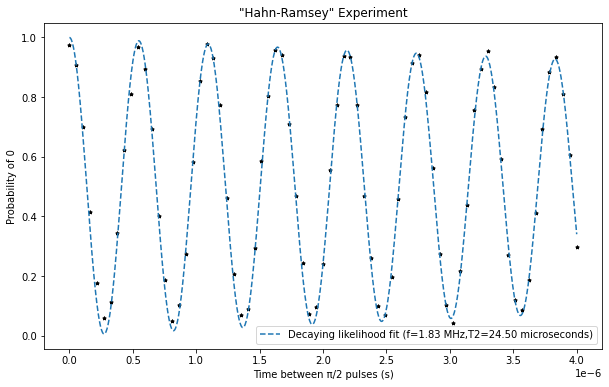

In [ ]:
def get_ramsey_values():
    ramsey_results = echoed_ramsey_job.result()
    ramsey_values = []
    results = ramsey_results.get_counts()
    for result in results:
        ramsey_values.append(result['0']/sum(result.values()))
    return(ramsey_values)

def decaying_likelihood(t, f, T2, pmax):
    return pmax*(np.exp(-t/T2)*np.cos(2*np.pi*f*t/2)**2+(1-np.exp(-t/T2))/2)

def fit_likelihood(ts, values, pmax, smoothen_interpolation=True, print_param=True):
    p0=[delta_f,10e-6]
    parameters,cov = curve_fit(lambda t,f,T2: decaying_likelihood(t,f,T2,pmax), 
                         ts, values, p0=p0)
    f,T2 = parameters
    ferr, T2err = np.sqrt(np.diag(cov))
    if print_param:
        print("Decaying likelihood curve fit:\n* f  = %.6f ± %.6f MHz\n"
              "* T2* = %.6f ± %.6f us"  % (f*1e-6,ferr*1e-6,T2*1e6,T2err*1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = decaying_likelihood(ts, *parameters, pmax)
    
    return parameters,ts,ys

def plot_ramsey_fit(offset=False):
    ramsey_values = get_ramsey_values()
    pmax = ramsey_values[0] if offset else 1
    (f,T2),extended_ts,ys = fit_likelihood(ts,ramsey_values,pmax)
    plt.figure(figsize=(10, 6))
    plt.scatter(ts, ramsey_values, s=12, color='black', marker='*')
    curve_label = ("Decaying likelihood fit (f=%.2f MHz,T2=%.2f microseconds)" % 
                   (f/1e6,T2*1e6))
    plt.plot(extended_ts,ys,linestyle='dashed',label=curve_label)
    plt.title("\"Hahn-Ramsey\" Experiment")
    plt.xlabel('Time between π/2 pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()

plot_ramsey_fit()

### Comparing the curve fit to the inference results

Decaying likelihood curve fit:
* f  = 1.827853 ± 0.000670 MHz
* T2* = 24.495239 ± 2.608171 us


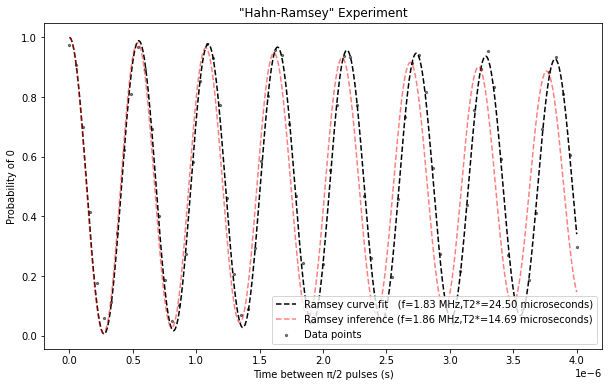

In [ ]:
def compare_inference(inference_params = [1.86,14.69]):
    pmax = 1
    ramsey_values = get_ramsey_values()
    (f,T2),extended_ts,ys = fit_likelihood(ts,ramsey_values,pmax)
    f2, T22 = inference_params
    f2, T22 = f2*1e6, T22*1e-6
    y2s = decaying_likelihood(extended_ts, f2, T22, pmax)

    plt.figure(figsize=(10, 6))
    plt.scatter(ts, ramsey_values, color='black',s=5,alpha=0.5,label='Data points')
    curve_label = ("Ramsey curve fit   (f=%.2f MHz,T2*=%.2f microseconds)" % 
                   (f/1e6,T2*1e6))
    curve_label2 = ("Ramsey inference (f=%.2f MHz,T2*=%.2f microseconds)" % 
                   (f2/1e6,T22*1e6))
    plt.plot(extended_ts,ys,color='black', linestyle='dashed',label=curve_label)
    plt.plot(extended_ts,y2s,color='red', linestyle='dashed',label=curve_label2,alpha=0.5)
    plt.title("\"Hahn-Ramsey\" Experiment")
    plt.xlabel('Time between π/2 pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()

compare_inference()

### Getting data for the inference

In [ ]:
delta_f = 1.83e6
tmin, tmax = 1e-6, 5e-6
nsched = 75; nshots = 2; runs = 1
rand = False
if rand:
  times = np.array([random.uniform(tmin,tmax) for i in range(nsched)])
else:
  times = np.linspace(tmin, tmax, nsched)

filename_start = configuration.backend_name[5:] + '_echoed_ramsey_data[' +    \
    str(round(tmin*1e6*2,1)) + ',' +  str(round(tmax*1e6)) + '[' +            \
    'f=' + str(round(delta_f*1e-6,2))  + ('(rand)' if rand else '') +         \
    '_sched=' + str(nsched) + '_nshots=' + str(nshots)

collect_data(lambda ts,nshots,monitor: run_echoed_ramsey_job(ts,
                                                             delta_f, 
                                                             nshots=nshots,
                                                             monitor=monitor), 
             times, runs, nshots, filename_start)

> Run 0.


/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Echoed ramsey job ID: '60bea01eac71df1085e6a7bf' [run_echoed_ramsey_job]
Job Status: job has successfully run
Run 0 data vector (length 150):  [(1.0, 0), (1.0, 0), (1.054054054054054, 0), (1.054054054054054, 0), (1.1081081081081081, 0), (1.1081081081081081, 1), (1.162162162162162, 0), (1.162162162162162, 0), (1.2162162162162162, 0), (1.2162162162162162, 0), (1.2702702702702704, 1), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3243243243243243, 1), (1.3783783783783785, 1), (1.3783783783783785, 1), (1.4324324324324325, 1), (1.4324324324324325, 0), (1.4864864864864866, 1), (1.4864864864864866, 1), (1.5405405405405403, 0), (1.5405405405405403, 0), (1.5945945945945947, 0), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.6486486486486485, 0), (1.7027027027027029, 0), (1.7027027027027029, 1), (1.7567567567567568, 0), (1.7567567567567568, 0), (1.810810810810811, 1), (1.810810810810811, 1), (1.864864864864865, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.918918918918919, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## <a name="T2"></a>Performing a Hahn Echo experiment to get an estimate of T2

In [ ]:
def get_Hahn_echo_schedules(total_times,method=2):
    # The actual delays will be half as long as the total evolution times
    #(one after each of the first 2 pulses). Also need to convert to backend 
    #time units/samples.
    with pulse.build(backend):
      total_samples = pulse.builder.seconds_to_samples(total_times/2)

    delays = np.array([get_closest_multiple_of_16(nsamples) 
                       for nsamples in total_samples])

    if method==0 or method==1:
        half_pi_pulse, pi_pulse = get_half_pi_pulse(q,backend.defaults()), \
            get_pi_pulse(q,backend.defaults()) 
        drive_channel = pulse.DriveChannel(q)
        measure = get_measure_pulse(q,backend.defaults()) 
    else:
        mq = pulse.MeasureChannel(q)
    t2_schedules = []
    for i,delay in enumerate(delays):
        if method==0:
            schedule = pulse.Schedule(name=f"T2 delay = {delay*dt} s")
            schedule |= pulse.Play(half_pi_pulse, drive_channel)
            schedule |= pulse.Play(pi_pulse, drive_channel) \
                << int(schedule.duration + delay)
            schedule |= pulse.Play(half_pi_pulse, drive_channel) \
                << int(schedule.duration + delay)
            schedule |= measure << int(schedule.duration)
        if method==1:
            schedule = pulse.Schedule(name=f"T2 delay = {delay*dt} s")
            schedule |= half_pi_pulse
            schedule |= pi_pulse << int(schedule.duration + delay)
            schedule |= half_pi_pulse \
                << int(schedule.duration + delay)
            schedule |= measure << int(schedule.duration)
        if method==2:
          with pulse.build(backend,name=f"Delay no. {i}") as schedule:
            with pulse.align_sequential():
              pulse.u2(0,np.pi,q) # Half pi rotation.
              pulse.delay(delay,mq)
              pulse.x(q) # Pi rotation.
              pulse.delay(delay,mq)
              pulse.u2(0,np.pi,q) # Half pi rotation.
              pulse.measure(q)  
        
        t2_schedules.append(schedule)     

    return t2_schedules 

def run_Hahn_echoes(taus,nshots=512,monitor=True):
    t2_schedules = get_Hahn_echo_schedules(taus)
    t2_experiment = backend.run(t2_schedules,
                            meas_level=2,
                            shots=nshots)

    ID = t2_experiment.job_id()
    print(f"Spin echo job ID: \'{ID}\' [run_spin_echo_job]")
    if monitor:
        job_monitor(t2_experiment)
    return(t2_experiment)

tmin, tmax = 0e-6, 2*t2_est
total_times = np.linspace(tmin, tmax, 75)
run_again = True
if run_again:
    t2_job = run_Hahn_echoes(total_times)
else:
    # 1024 shots
    #t2_job = backend.retrieve_job('60b66647266098e4ad204303')
    # 512 shots
    tmax = 50e-6 
    times = np.linspace(0, tau_max, 75)*2
    t2_job = backend.retrieve_job('60b676c13f8a4b6ef9d19c6e')
#60b7c4f46b8ea80ef190f3ae

/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Spin echo job ID: '60b7d5546035e60e635b7b26' [run_spin_echo_job]
Job Status: job has successfully run


### Fitting a curve

Hahn echo likelihood curve fit:
* T2 = 51.947212 ± 45.705276 us


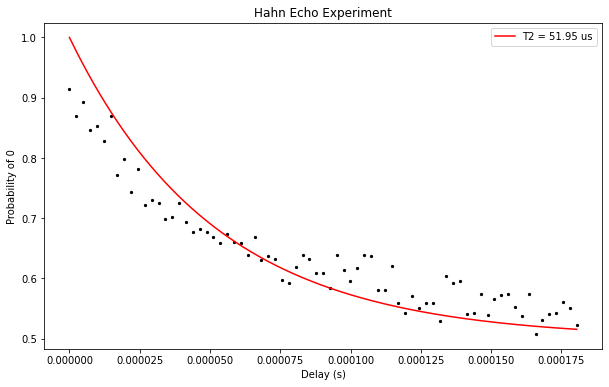

In [ ]:
def get_t2_values():
    t2_results = t2_job.result(timeout=120)
    t2_values = []
    results = t2_results.get_counts()
    for result in results:
        p0 = 0 if '0' not in result else result['0']/sum(result.values())
        t2_values.append(p0)
    return t2_values

def spin_echo_likelihood(t, T2):
    return 0.5*np.exp(-t/T2)+0.5

def fit_t2_likelihood(ts, values, smoothen_interpolation=True,print_param=True):
    p0 = [t2_est]
    param,cov = curve_fit(lambda t,T2: spin_echo_likelihood(t,T2),ts, values,
                      p0=p0,absolute_sigma=True)
    T2 = param[0]
    if print_param:
        err = np.sqrt(np.diag(cov))[0]
        print("Hahn echo likelihood curve fit:\n* T2 = %.6f ± %.6f us" % (T2*1e6,err*1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = spin_echo_likelihood(ts, T2)
    
    return T2,ts,ys

def show_t2_echoed():
    t2_values = get_t2_values()
    T2,extended_ts, ys = fit_t2_likelihood(total_times,t2_values)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(total_times, np.real(t2_values), color='black',s=5)
    plt.plot(extended_ts, ys, color='red', label=f"T2 = {T2*1e6:.2f} us")
    plt.xlabel('Delay (s)')
    plt.ylabel('Probability of 0')
    plt.title('Hahn Echo Experiment')
    plt.legend()
    plt.show()

show_t2_echoed()

### Comparing the curve fit to the inference results

Hahn echo likelihood curve fit:
* T2 = 51.947212 ± 45.705276 us


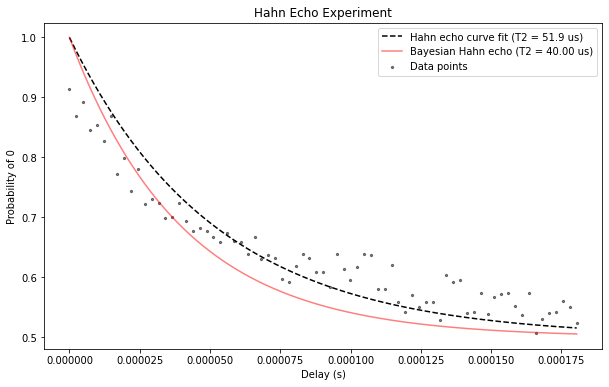

In [ ]:
def compare_inference(inference_T2 = 40):
    t2_values = get_t2_values()
    T2,extended_ts, ys = fit_t2_likelihood(total_times,t2_values)
    y2s = spin_echo_likelihood(extended_ts,inference_T2*1e-6)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(total_times, np.real(t2_values), color='black',s=5,alpha=0.5,label='Data points')
    plt.plot(extended_ts, ys, color='black', linestyle='dashed',
             label=f"Hahn echo curve fit (T2 = {T2*1e6:.1f} us)")
    plt.plot(extended_ts, y2s, color='red', alpha=0.5, #linestyle='dashed',
             label=f"Bayesian Hahn echo (T2 = {inference_T2:.2f} us)")
    plt.xlabel('Delay (s)')
    plt.ylabel('Probability of 0')
    plt.title('Hahn Echo Experiment')
    plt.legend()
    plt.show()

compare_inference()

### Getting data for the inference


In [ ]:
tmin, tmax = 0.4e-6, 1.5*t2_est
nsched = 75; nshots = 30; runs = 1
rand = False
if rand:
  times = np.array([random.uniform(tmin,tmax) for i in range(nsched)])
else:
  times = np.linspace(tmin, tmax, nsched)

filename_start = configuration.backend_name[5:] + '_spin_echo_data_t∈[' +   \
    str(round(tmin*1e6,1)) + ',' +  str(round(tmax*1e6)) + '[' + \
    'T2_est=' + str(round(t2_est*1e6))  + ('(rand)' if rand else '') +     \
    '_sched=' + str(nsched) + '_nshots=' + str(nshots)

collect_data(run_Hahn_echoes, times, runs, nshots, filename_start)

## <a name="T1"></a>Performing an experiment to get the energy relaxation time T1

In [ ]:
def get_T1_schedules(times):
    # The actual delays will be half as long as the total evolution times
    #(one after each of the first 2 pulses). Also need to convert to backend 
    #time units/samples.
    with pulse.build(backend):
      total_samples = pulse.builder.seconds_to_samples(times)
    delays = np.array([get_closest_multiple_of_16(nsamples) 
                       for nsamples in total_samples])
    
    mq = pulse.MeasureChannel(q)
    t1_schedules = []
    for i,delay in enumerate(delays):
        with pulse.build(backend,default_alignment='sequential', 
                          name=f"Delay no. {i}") as schedule:
          pulse.x(q) # Pi rotation.
          pulse.delay(delay,mq)
          pulse.measure(q)  
        t1_schedules.append(schedule)     

    return t1_schedules 

def run_T1_experiment(times,nshots=512,monitor=True):
    t1_schedules = get_T1_schedules(times)
    t1_experiment = backend.run(t1_schedules,
                            meas_level=2,
                            shots=nshots)

    ID = t1_experiment.job_id()
    print(f"T1 job ID: \'{ID}\' [run_spin_echo_job]")
    if monitor:
        job_monitor(t1_experiment)
    return(t1_experiment)

tmin, tmax = 20e-6, 3*t1_est
times = np.linspace(tmin, tmax, 75)
run_again = False
if run_again:
    t1_job = run_T1_experiment(times)
else:
    times = np.linspace(0, 3*48.6e-6, 75)
    t1_job = backend.retrieve_job('60b9121ae6e6410d342ec95c')

#print(t1_est)

### Fitting a curve

T1 likelihood curve fit:
* T1 = 67.234490 ± 25.564134 us


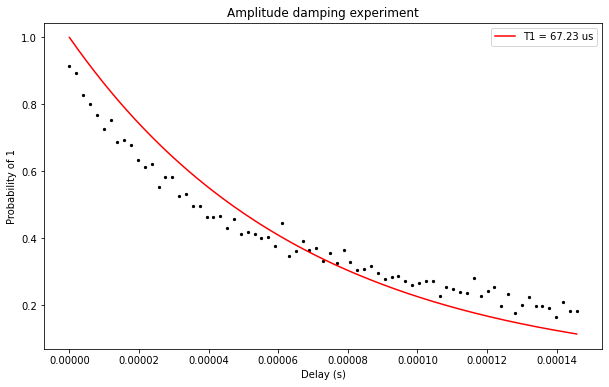

In [ ]:
def get_t1_values():
    t1_results = t1_job.result(timeout=120)
    t1_values = []
    results = t1_results.get_counts()
    for result in results:
        p1 = 0 if '1' not in result else result['1']/sum(result.values())
        t1_values.append(p1)
    return t1_values

def T1_likelihood(t, T1):
    return np.exp(-t/T1)

def fit_t1_likelihood(ts, values, smoothen_interpolation=True,print_param=True):
    p0 = [t1_est]
    param,cov = curve_fit(lambda t,T1: T1_likelihood(t,T1),ts, values,p0=p0,
                          absolute_sigma=True)
    T1 = param[0]
    if print_param:
        err = np.sqrt(np.diag(cov))[0]
        print("T1 likelihood curve fit:\n* T1 = %.6f ± %.6f us" % (T1*1e6,err*1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = T1_likelihood(ts, T1)
    
    return T1,ts,ys

def show_t1_echoed():
    t1_values = get_t1_values()
    T1,extended_ts, ys = fit_t1_likelihood(times,t1_values)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(times, np.real(t1_values), color='black',s=5)
    plt.plot(extended_ts, ys, color='red', label=f"T1 = {T1*1e6:.2f} us")
    plt.xlabel('Delay (s)')
    plt.ylabel('Probability of 1')
    plt.title('Amplitude damping experiment')
    plt.legend()
    plt.show()

show_t1_echoed()

### Comparing the curve fit to the inference results

T1 likelihood curve fit:
* T1 = 67.234490 ± 25.564134 us


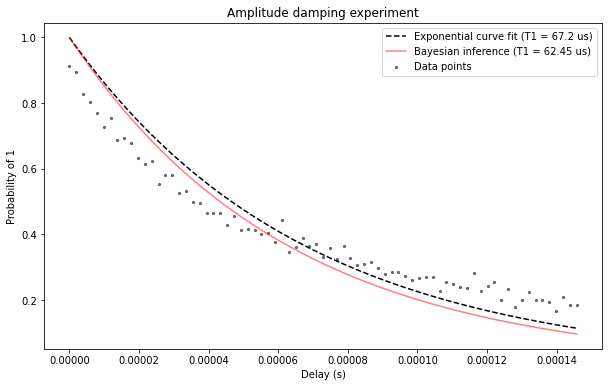

In [ ]:
def compare_inference(inference_T1 = 62.45):
    t1_values = get_t1_values()
    T1,extended_ts, ys = fit_t1_likelihood(times,t1_values)
    y2s = T1_likelihood(extended_ts,inference_T1*1e-6)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(times, np.real(t1_values), color='black',s=5,alpha=0.5,label='Data points')
    plt.plot(extended_ts, ys, color='black', linestyle='dashed',
             label=f"Exponential curve fit (T1 = {T1*1e6:.1f} us)")
    plt.plot(extended_ts, y2s, color='red', alpha=0.5, #linestyle='dashed',
             label=f"Bayesian inference (T1 = {inference_T1:.2f} us)")
    plt.xlabel('Delay (s)')
    plt.ylabel('Probability of 1')
    plt.title('Amplitude damping experiment')
    plt.legend()
    plt.show()

compare_inference()

### Getting data for the inference

In [ ]:
tmin, tmax = 1e-6, t1_est
nsched = 75; nshots = 20; runs = 10
rand = False
if rand:
  times = np.array([random.uniform(tmin,tmax) for i in range(nsched)])
else:
  times = np.linspace(tmin, tmax, nsched)

filename_start = configuration.backend_name[5:] + '_amplitude_damping_data[' + \
    str(round(tmin*1e6*2,1)) + ',' +  str(round(tmax*1e6)) + '[' +           \
    'T1_est=' + str(round(t1_est*1e6))  + ('(rand)' if rand else '') +         \
    '_sched=' + str(nsched) + '_nshots=' + str(nshots)

collect_data(run_T1_experiment, times, runs, nshots, filename_start)

> Run 0.


/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


T1 job ID: '60b8f8c09af47d4fc82d2f56' [run_spin_echo_job]
> Run 1.
T1 job ID: '60b8f8c16b8ea854f591063a' [run_spin_echo_job]
> Run 2.
T1 job ID: '60b8f8c2e6e64164402ec7f6' [run_spin_echo_job]
> Run 3.
T1 job ID: '60b8f8c39af47d2ba32d2f57' [run_spin_echo_job]
> Run 4.
T1 job ID: '60b8f8c5be6c304b990350f8' [run_spin_echo_job]
Job Status: job has successfully run
Run 0 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b9111bf120a70742b8f81d' [run_spin_echo_job]
Job Status: job has successfully run
Run 1 data vector (length 1500):  [(1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b911266035e62dbd5b8d1e' [run_spin_echo_job]
Job Status: job has successfully run
Run 2 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b911326b8ea832e291077d' [run_spin_echo_job]
Job Status: job has successfully run
Run 3 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b9113e0180475ba4916932' [run_spin_echo_job]
Job Status: job has successfully run
Run 4 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b9114a018047c75d916934' [run_spin_echo_job]
Job Status: job has successfully run
Run 5 data vector (length 1500):  [(1.0, 1), (1.0, 0), (1.0, 0), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 6 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 7 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 8 data vector (length 1500):  [(1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 9 data vector (length 1500):  [(1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>